In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [2]:
%%capture
%load_ext rpy2.ipython
%R require(ggplot2)

In [3]:
from helpers.notebooks import notebooks_importer

In [4]:
%%capture
import Breast_cancer_data as data

## Previously reported cancer stratification

On example of a well studied breast invasive carcinoma (BRCA) cohort from TCGA, as studied and reported by TCGA PanCancer Atlas in 2018.

In [5]:
from data_sources.pan_cancer_atlas import PanCancerAtlas

### PAM 50
- based on mRNA expression
- applied to breast cancer samples by (The Cancer Genome Atlas Network, 2012)

In [6]:
pam50_subtypes = PanCancerAtlas().subtypes_curated()

Please refer to https://www.bioconductor.org/packages/devel/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html for the source of data for specific cohorts


In [7]:
pam50_brca = pam50_subtypes[pam50_subtypes.cancer_type == 'BRCA']

In [8]:
pam50_brca.dropna(axis=1).head()

,pan_samplesid,cancer_type,subtype_mrna,subtype_protein,subtype_selected,participant
407,TCGA-E2-A158-11A-22R-A12D-07,BRCA,Normal,-2147483648,BRCA.Normal,A158
408,TCGA-BH-A0DD-11A-23R-A12P-07,BRCA,LumA,-2147483648,BRCA.LumA,A0DD
409,TCGA-BH-A1EO-11A-31R-A137-07,BRCA,LumA,-2147483648,BRCA.LumA,A1EO
410,TCGA-BH-A0B5-11A-23R-A12P-07,BRCA,LumA,-2147483648,BRCA.LumA,A0B5
411,TCGA-A7-A13G-11A-51R-A13Q-07,BRCA,LumA,-2147483648,BRCA.LumA,A13G


For detailed description see: https://www.bioconductor.org/packages/devel/bioc/vignettes/TCGAbiolinks/inst/doc/subtypes.html

The *Subtype_Selected* column is equivalent to mRNA for BRCA:

In [9]:
assert ((pam50_brca.cancer_type + '.' + pam50_brca.subtype_mrna) == pam50_brca.subtype_selected).all()

While *Subtype_protein* has no variance at all:

In [10]:
pam50_brca.subtype_protein.unique()

array([-2147483648])

There are five subtypes in PAM 50 model:

In [11]:
pam50_brca.subtype_mrna.value_counts()

LumA      581
LumB      219
Basal     193
Normal    143
Her2       82
Name: subtype_mrna, dtype: int64

#### Coverage of PAM 50

There are subtypes assigned for every sample in BRCA cohort:

In [12]:
samples = set(data.brca_expression.columns)
pam_50_samples = set(pam50_brca.pan_samplesid)

In [13]:
len(samples & pam_50_samples) / len(samples)

1.0

In [14]:
df = pam50_brca.set_index('participant')[['subtype_mrna']].unstack().reset_index()
df.drop_duplicates()[0].value_counts()

LumA      568
LumB      217
Basal     192
Normal    140
Her2       82
Name: 0, dtype: int64

#### PAM 50 allows to consider cancer heteregonity

Worth noting: in some cases there is more than one subtype per participant (which is kind of obvious when considering the cancer heterogeneity):

In [15]:
heterogenous = pam50_brca.groupby('participant').filter(lambda row: len(set(row.subtype_mrna)) > 1)

In [16]:
# ignore multiple samples (just look at the participants)
heterogenous_participants = heterogenous.drop_duplicates(subset=['participant', 'subtype_mrna'])[['participant', 'subtype_mrna']]

In [17]:
h = len(heterogenous_participants.participant.unique())
a = len(pam50_brca.participant.unique())
print(f'There are {h} participants (out of {a}) with heterogenity, so about {h/a*100:.2f}%')

There are 102 participants (out of 1097) with heterogenity, so about 9.30%


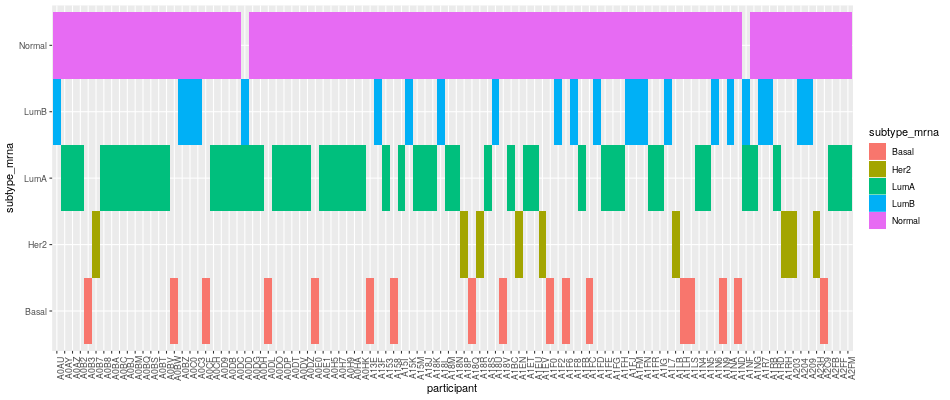

In [18]:
%%R -i heterogenous_participants -w 950 -h 400 -u px
(
    ggplot(heterogenous_participants, aes(x=participant, y=subtype_mrna, fill=subtype_mrna))
    + geom_tile()
    + theme(axis.text.x=element_text(angle=90))
)

In [19]:
heterogenous_groups = heterogenous_participants.groupby('participant').subtype_mrna.apply(lambda subtypes: ' and '.join(sorted(set(subtypes)))).to_dict()
heterogenous_participants['grouped'] = heterogenous_participants.participant.map(heterogenous_groups)
count_fraction = heterogenous_participants.groupby('participant').subtype_mrna.apply(lambda subtypes: 1/len(set(subtypes))).to_dict()
heterogenous_participants['Count'] = heterogenous_participants.participant.map(count_fraction)

In [20]:
heterogenous_participants = heterogenous_participants.sort_values('grouped')

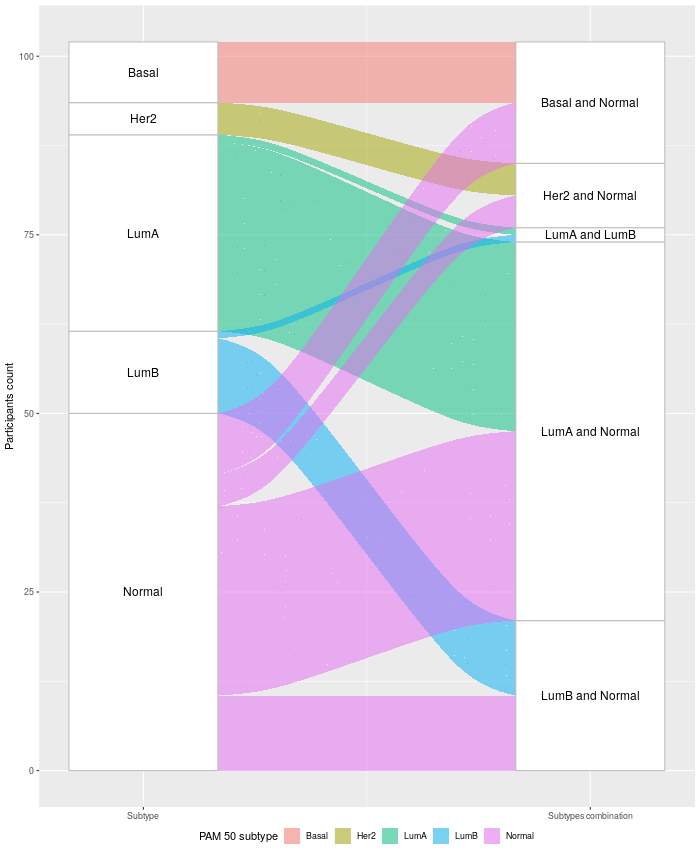

In [21]:
%%R -i heterogenous_participants -w 700 -h 850 -u px
library(ggalluvial)
g = (
    ggplot(heterogenous_participants, aes(axis1=subtype_mrna, axis2=grouped, y=Count))
    + ggalluvial::geom_alluvium(aes(fill=subtype_mrna))
    + ggalluvial::geom_stratum(width=1/3, fill='white', color = 'grey')
    + ggfittext::geom_fit_text(stat='stratum', label.strata=T, min.size=3, width=1/4)
    + scale_x_continuous(breaks=1:2, labels = c('Subtype', 'Subtypes combination'))
    + ylab('Participants count')
    #+ ggtitle('BRCA heteregonity in TCGA (PAM 50)')
    + labs(fill='PAM 50 subtype')
    + theme(
        legend.position='bottom',
        legend.margin=margin(t=-.2, unit='cm'),
    )
)
ggsave(file="pam50_heterogenity.png", plot=g, width=7*1.4, height=8.5*1.4, dpi=140)
g

### iCluster
- based on copy number, DNA methylation, mRNA and miRNA
- applied to all cancer types (pan-cancer clustering) by (Hoadley et al., 2018).

In [22]:
icluster_subtypes = PanCancerAtlas().icluster()

In [23]:
icluster_subtypes.icluster = 'IC' + icluster_subtypes.icluster.astype(str)

In [24]:
participants_with_brca = {
    barcode.participant
    for barcode in data.brca_expression.barcodes
}

In [25]:
icluster_brca = icluster_subtypes[icluster_subtypes.participant.isin(participants_with_brca)]

In [26]:
icluster_brca.head()

,sample_id,icluster,participant
4759,TCGA-3C-AAAU,IC19,AAAU
4760,TCGA-3C-AALI,IC2,AALI
4761,TCGA-3C-AALJ,IC17,AALJ
4762,TCGA-3C-AALK,IC2,AALK
4763,TCGA-4H-AAAK,IC19,AAAK


Some subtypes are assigned to only few (or even one) participants. Those may be mis-classifications or patients with metastasis (or just multiple cancers).

In [27]:
# upper numbers = custers, lower row = participants counts
HorizontalNamespace(icluster_brca.icluster.value_counts())

IC19,IC17,IC2,IC20,IC13,IC25,IC14,IC10,IC8,IC27,IC7,IC3,IC1,IC22,IC23
553,125,98,78,68,39,17,16,10,10,9,4,1,1,1


For the analysis I will exclude clusters with less than 3 samples (required number of samples for differential expression with signal-to-ratio and tTest metrics):

In [28]:
samples_by_participant = data.brca_expression.samples_by_participant()

In [29]:
def sampels_count_in_cluster(participants):
    return sum([
        len(samples_by_participant[participant])
        for participant in participants
    ])

In [30]:
sampels_in_cluster = icluster_brca.groupby('icluster').participant.apply(sampels_count_in_cluster)

In [31]:
# upper numbers = custers, lower row = samples counts
HorizontalNamespace(sampels_in_cluster)

IC1,IC10,IC13,IC14,IC17,IC19,IC2,IC20,IC22,IC23,IC25,IC27,IC3,IC7,IC8
2,18,75,20,136,620,108,84,1,1,44,11,4,11,11


In [32]:
selecetd_clusters = set(sampels_in_cluster[sampels_in_cluster > 3].index)
icluster_brca_selected = icluster_brca[icluster_brca.icluster.isin(selecetd_clusters)]

In [33]:
# upper numbers = custers, lower row = participants counts
HorizontalNamespace(icluster_brca_selected.icluster.value_counts())

IC19,IC17,IC2,IC20,IC13,IC25,IC14,IC10,IC8,IC27,IC7,IC3
553,125,98,78,68,39,17,16,10,10,9,4


#### Coverage of iCluster subtypes

The coverage is high when all subtypes are included (94.24%)

In [34]:
participants_icluster = set(icluster_brca.participant)
len(participants_with_brca & participants_icluster) / len(participants_with_brca)

0.9423604757548033

And remains comparable (93.96%) after exclusion of the three small clusters:

In [35]:
participants_icluster_selected = set(icluster_brca_selected.participant)
len(participants_with_brca & participants_icluster_selected) / len(participants_with_brca)

0.939615736505032

### PARADIGM
- based on mRNA expression, copy number and pathway interaction data (NCIPID, BioCarta, Reactome),
- "PARADIGM pathway analysis followed by unsupervised consensus clustering of pathway scores that clustered samples primarily by tissue type"
- applied to gynecologic and breast cancers by (Berger et al., 2018),

Methodology extracts (open access, [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/), Berger et al):

> The PARADIGM algorithm infers an integrated pathway level (IPL) for each feature that reflects the log likelihood of the probability that it is activated (vs. inactivated). PARADIGM IPLs of the 19504 features within the SuperPathway is available on Synapse (syn6171376).

> We also computed the single sample gene set enrichment (ssGSEA) score, as described by Barbie et al (Barbie et al., 2009), of the constituent pathways forming the SuperPathway structure from the PARADIGM IPL data using the GSVA package in R (Hänzelmann et al., 2013). Of the 1524 pathways obtained, only 1387 have pathway members within the interconnected SuperPathway structure; and their ssGSEA scores are available on Synapse (syn10184122).

> Consensus Clustering based on PARADIGM Inferred Pathway Activation
Consensus clustering based on the 4876 most varying features (i.e. IPLs with variance within the highest quartile) was used to identify Pan-Gynecological subtypes implicated from shared patterns of pathway inference. Consensus clustering was implemented with the ConsensusClusterPlus package in R (Wilkerson and Hayes, 2010)

In [36]:
brca_subtypes_integrative = PanCancerAtlas().subtypes_integrative('BRCA')

/home/krassowski/.pyenv/versions/3.7.0/envs/drug_discovery/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: brca subtype information from:doi.org/10.1016/j.ccell.2018.03.014

  warnings.warn(x, RRuntimeWarning)


In [37]:
# just to avoid confusion with Pan-Gyn clusters names
brca_subtypes_integrative.paradigm_clusters = 'PR' + brca_subtypes_integrative.paradigm_clusters

In [38]:
paradigm_brca = brca_subtypes_integrative.dropna(subset=['paradigm_clusters'])

In [39]:
HorizontalNamespace(paradigm_brca.paradigm_clusters.value_counts())

PRC5,PRC6,PRC4,PRC8,PRC2,PRC1,PRC7
356,271,247,103,75,1,1


Clusters with less than 3 samples are (again) excluded:

In [40]:
sampels_in_cluster = paradigm_brca.groupby('paradigm_clusters').participant.apply(sampels_count_in_cluster)

In [41]:
selecetd_clusters = set(sampels_in_cluster[sampels_in_cluster > 3].index)
paradigm_brca_selected = paradigm_brca[paradigm_brca.paradigm_clusters.isin(selecetd_clusters)]

In [42]:
HorizontalNamespace(paradigm_brca_selected.paradigm_clusters.value_counts())

PRC5,PRC6,PRC4,PRC8,PRC2
356,271,247,103,75


#### Coverage of PARADIGM clustering

Is again, high: 96.07%

In [43]:
participants_paradigm = set(paradigm_brca_selected.participant)
len(participants_with_brca & participants_paradigm) / len(participants_with_brca)

0.9606587374199451

### Cluster of Cluster Assignments (CoCA) integrative analysis

> We used cluster assignments from the six major TCGA platforms (mutations, SCNA, DNA methylation, mRNA, miRNA, and protein) to perform integrated clustering across the Pan-Gyn cohort using the CoCA algorithm. 

> The resulting CoCA clusters were heavily dominated by tumor type because the intrinsic gene expression patterns were lineage dependent. The association with tumor type was especially prominent in the DNA methylation, mRNA, miRNA, and protein clusters.

> Therefore, we turned to an alternative method (described next) to define subtypes that would span the Pan-Gyn tumor types and emphasize high-level similarities among them.

It seems that the CoCA clusters are not included (which seems ok, given that related figure only made it to supplementary files), but there are clusterings for each of the molecular platforms! So I could re-use these (but looking at BRCA only) and possibly get something interesting. Actually, there are many interesting ways of doing the consensus clustering...

But lets skip it for now as there are more pressing matters.

### Subtypes across the Pan-Gyn Tumors
> We present molecular subtypes that illuminate commonalities and distinguishing features across the Pan-Gyn tumor types, with the potential to inform future cross-tumor-type therapies. We first identified 16 features (listed in the STAR Methods) across 1,956 samples that were either (1) currently used in the clinic for at least 1 of the 5 tumor types, or (2) identified as informative in previous TCGA gynecologic and breast cancer studies

this is less granular clustering than PAM 50, but captures similarities on a higher level (as other gynecologic tumours were considered as well). Two examples, just to give an idea of the cluster meanings:

> SCNA load was the predominant feature and produced the first division. In the low-SCNA-load group, we found two clusters, non-hypermutator (C1) and hypermutator (C2). The non-hypermutator cluster had virtually no hypermutators but had high levels of ER+, PR+, and/or AR+ samples, indicating potential susceptibility to hormone therapies. C2, the hypermutator cluster, could be further subdivided into four subclusters (clusters C2A-C2D).

Sanity check: this clustering should have five clusters: C1-C5

In [44]:
pan_gyn_clusters_brca = brca_subtypes_integrative.dropna(subset=['pan_gyn_clusters'])

In [45]:
HorizontalNamespace(pan_gyn_clusters_brca.pan_gyn_clusters.value_counts())

C1,C3,C5,C4,C2
300,198,183,144,52


#### Coverage of Pan-Gyn

For pan-gyn clusters the coverage is relatively low (79.78% participants);

In [46]:
participants_pan_gyn = set(pan_gyn_clusters_brca.participant)
len(participants_with_brca & participants_pan_gyn) / len(participants_with_brca)

0.797804208600183

## Summary

Only curated PAM 50 subtypes are sample specific. Clusters from other papers are assigned to participants (patients), not to samples - which kind of makes sense, once we combine information from different omics we no longer have a single sample (unless we could match e.g. DNA/expression samples). But then the heterogeneity information is lost as well - which means that for about 10% of participants the explanations will be incomplete.

### All stratifications together

#### Participant-level

In [47]:
pam50_adapted = pam50_brca[['participant', 'subtype_mrna']].drop_duplicates()
pam50_adapted.subtype_mrna = pam50_adapted.participant.map(heterogenous_groups).fillna(pam50_adapted.subtype_mrna)

In [48]:
pam50_adapted.head()

,participant,subtype_mrna
407,A158,Basal and Normal
408,A0DD,LumA and LumB
409,A1EO,LumA
410,A0B5,LumA
411,A13G,LumA


In [49]:
considered_stratifications = {
    'subtype_mrna': pam50_adapted,
    'icluster': icluster_brca_selected,
    'paradigm_clusters': paradigm_brca_selected,
    'pan_gyn_clusters': pan_gyn_clusters_brca,    
}

In [50]:
all_stratifications = concat([
    df.rename({custering_name: 'cluster'}, axis=1)[['participant', 'cluster']].drop_duplicates().assign(group=custering_name)
    for custering_name, df in considered_stratifications.items()
]).sort_values(['group', 'cluster'])

In [51]:
from helpers.plots.alluvium import suggest_groups_ordering, determine_order_for_clusters_in_groups

In [52]:
ordering_ranking = suggest_groups_ordering(all_stratifications)
ordering_ranking.head()

subtype_mrna       paradigm_clusters  pan_gyn_clusters   icluster             0.653327
paradigm_clusters  subtype_mrna       icluster           pan_gyn_clusters     0.653327
subtype_mrna       icluster           pan_gyn_clusters   paradigm_clusters    0.626636
icluster           subtype_mrna       paradigm_clusters  pan_gyn_clusters     0.626636
paradigm_clusters  subtype_mrna       pan_gyn_clusters   icluster             0.572720
dtype: float64

I am choosing the first one (additional benefit of having the curated, well established PAM 50 on the left side)

In [53]:
order = ordering_ranking.index[0]

In [54]:
# clusters in the PAM 50 groups should be ordered by similarity (when possible) (so do not separate clusters that are similar).
# Globally impossible, so lets evaluate combinations to elimiate the worst cases:
from itertools import combinations, permutations
pam_50 = all_stratifications[all_stratifications.group == 'subtype_mrna']
ranked_permutations = {}
for permutation in permutations(pam_50.cluster.unique()):
    score = 0
    for i, current in enumerate(permutation[1:], 1):
        previous = permutation[i - 1]
        if previous in current.split(' and ') or current in previous.split(' and '):
            score += 1
    ranked_permutations[permutation] = score

In [55]:
chosen_pam_order = Series(ranked_permutations).sort_values(ascending=False).index[0]

In [56]:
counts = all_stratifications.cluster.value_counts().reset_index().rename({'index': 'group'}, axis=1)
HorizontalNamespace(**counts.set_index('group').cluster.to_dict())

IC19,LumA,PRC5,C1,PRC6,PRC4,C3,LumB,C5,Basal,C4,IC17,PRC8,IC2,IC20,PRC2,Her2,IC13,LumA and Normal,C2,Normal,IC25,LumB and Normal,Basal and Normal,IC14,IC10,IC8,IC27,Her2 and Normal,IC7,IC3,LumA and LumB
553,513,356,300,271,247,198,194,183,175,144,125,103,98,78,75,73,68,53,52,40,39,21,17,17,16,10,10,9,9,4,2


In [57]:
ordering_method = 'by_size' 
all_group_orders = (
    [
        *chosen_pam_order,
        *[
            c.group
            for c in counts.itertuples()
            if c.group not in chosen_pam_order
        ]
    ]
    if ordering_method == 'alternative' else
    list(counts.group)
)

In [58]:
all_stratifications.group = pd.Categorical(all_stratifications.group, ordered=True, categories=order)
assert set(all_group_orders) == set(all_stratifications.cluster.unique())

In [59]:
all_stratifications.cluster = pd.Categorical(all_stratifications.cluster, ordered=True, categories=all_group_orders)

In [60]:
corresponding_pam50 = all_stratifications[all_stratifications.group=='subtype_mrna'].set_index('participant').cluster.to_dict()

In [61]:
all_stratifications['corresponding_pam50'] = all_stratifications.participant.map(corresponding_pam50)

In [62]:
all_stratifications.to_pickle('published_brca_stratifications.pickle')

In [63]:
all_stratifications

,participant,cluster,group,corresponding_pam50
4826,A0T0,IC10,icluster,Basal
4953,A08R,IC10,icluster,Basal
5051,A0FJ,IC10,icluster,Basal
5084,A0J6,IC10,icluster,Basal
5138,A1AH,IC10,icluster,Basal
...,...,...,...,...
1578,A8FZ,Normal,subtype_mrna,Normal
1583,A8HR,Normal,subtype_mrna,Normal
1592,A9QF,Normal,subtype_mrna,Normal
1605,A97C,Normal,subtype_mrna,Normal


In [64]:
all_stratifications[all_stratifications.corresponding_pam50.isnull()]

,participant,cluster,group,corresponding_pam50
280,A5EI,C1,pan_gyn_clusters,NaN
712,A9FZ,C4,pan_gyn_clusters,NaN


In [65]:
pam50_brca[pam50_brca.participant.isin(['A5EI', 'A9FZ'])]

,pan_samplesid,cancer_type,subtype_mrna,subtype_dnameth,subtype_protein,...,subtype_cna,subtype_integrative,subtype_other,subtype_selected,participant


In [66]:
from data_sources.tcga import TCGA
tcga = TCGA()

In [67]:
clinical_brca_data = tcga.clinical('BRCA')

In [68]:
clinical_brca_data[clinical_brca_data.participant.isin(['A5EI', 'A9FZ'])]

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,...,histological_type,number_of_lymph_nodes,race,ethnicity,participant
TCGA-AC-A5EI,value,88,0,NaN,442,...,"other, specify",1,white,not hispanic or latino,A5EI
TCGA-C8-A9FZ,value,49,0,NaN,592,...,mixed histology (please specify),3,white,not hispanic or latino,A9FZ


In [69]:
all_stratifications.corresponding_pam50 = all_stratifications.corresponding_pam50.fillna('Unknown')

In [70]:
participant_to_sample = pam50_brca[['pan_samplesid', 'participant']]

#### Sample-level

In [71]:
stratifications_mapped_to_samples = {}

for name, stratification in considered_stratifications.items():
    stratifications_mapped_to_samples[name] = (
        stratification
        .merge(participant_to_sample, on='participant')
    )

stratifications_mapped_to_samples['subtype_mrna'] = pam50_brca[
    ['pan_samplesid', 'participant', 'subtype_mrna']
]

In [72]:
all_stratifications_samples = concat([
    df.rename({custering_name: 'cluster'}, axis=1)[['pan_samplesid', 'participant', 'cluster']].drop_duplicates().assign(group=custering_name)
    for custering_name, df in stratifications_mapped_to_samples.items()
]).sort_values(['group', 'cluster'])

In [73]:
corresponding_pam50 = all_stratifications_samples[
    all_stratifications_samples.group=='subtype_mrna'
].set_index('pan_samplesid').cluster.to_dict()

In [74]:
all_stratifications_samples['corresponding_pam50'] = all_stratifications_samples.pan_samplesid.map(corresponding_pam50)

In [75]:
assert not all_stratifications_samples.isnull().any().any()

In [76]:
all_stratifications_samples

,pan_samplesid,participant,cluster,group,corresponding_pam50
67,TCGA-A2-A0T0-01A-22R-A084-07,A0T0,IC10,icluster,Basal
201,TCGA-A8-A08R-01A-11R-A034-07,A08R,IC10,icluster,Basal
301,TCGA-AN-A0FJ-01A-11R-A00Z-07,A0FJ,IC10,icluster,Basal
334,TCGA-AO-A0J6-01A-11R-A034-07,A0J6,IC10,icluster,Basal
388,TCGA-AR-A1AH-01A-11R-A12D-07,A1AH,IC10,icluster,Basal
...,...,...,...,...,...
1583,TCGA-C8-A8HR-01A-11R-A36F-07,A8HR,Normal,subtype_mrna,Normal
1592,TCGA-LD-A9QF-01A-32R-A41B-07,A9QF,Normal,subtype_mrna,Normal
1605,TCGA-OL-A97C-01A-32R-A41B-07,A97C,Normal,subtype_mrna,Normal
1616,TCGA-PL-A8LY-01A-11R-A41B-07,A8LY,Normal,subtype_mrna,Normal


### Summary-table

In [77]:
stratifications_summary = DataFrame([
    {
        'id': 'icluster',
        'name': 'iCluster',
        'reference': '(Hoadley et al., 2018)',
        'based_on': ['CNV', 'DNA methylation', 'mRNA', 'miRNA']
    },
    {
        'id': 'subtype_mrna',
        'name': 'PAM 50',
        'reference': '(TCGA Network, 2012)',
        'based_on': ['mRNA']
    },
    {
        'id': 'paradigm_clusters',
        'name': 'PARADIGM',
        'reference': '(Berger et al., 2018)',
        'based_on': ['CNV', 'mRNA', 'Pathways (NCIPID, BioCarta, Reactome)']
    },
    {
        'id': 'pan_gyn_clusters',
        'name': 'Pan-Gyn',
        'reference': '(Berger et al., 2018)',
        'based_on': []
    }
]).set_index('id')

### Sample-level comparison with PAM 50

In [78]:
heatmap = copy(all_stratifications_samples).reset_index(drop=True)
heatmap['x'] = 0
heatmap['y'] = 0

width = 20

def cluster_size(c):
    return -len(c[1])

start_by_group = {}
height_by_group = {}
cluster_names = []
annotations = []
y = 0

for group, data in heatmap.groupby('group'):
    start_by_group[group] = y
    x = 0
    
    for cluster, cluster_d in sorted(
        data.groupby('cluster'), key=cluster_size
    ):
        cluster_y_start = y
        for corresponding_pam50_group, d in sorted(
            cluster_d.groupby('corresponding_pam50'),
            key=cluster_size
        ):
            last = False
            for index, row in d.iterrows():
                heatmap.loc[index, 'x'] = x
                heatmap.loc[index, 'y'] = y
                x += 1
                if x == width:
                    y += 1
                    x = 0
                    last = True
                else:
                    last = False
            if last:
                y -= 1
        cluster_h = y - cluster_y_start
        y_center = cluster_y_start + (cluster_h) / 2
        cluster_names.append({
            'y': y_center,
            'name': cluster
        })
        samples_n = len(cluster_d)
        patients_n = len(set(cluster_d.participant))
        size = 1
        if samples_n <  width:
            label = f'{samples_n}/{patients_n}'
            size = 3.5/4
        elif cluster_h > 3:
            label = f'{samples_n} samples\n{patients_n} participants'
            size = 1.1
            y_center -= 0.5
        else:
            label = f'{samples_n} samples / {patients_n} participants'
            size = 3.6/4
        annotations.append({
            'y': y_center,
            'label': label,
            'x': min(width, samples_n) /2 - 0.5,
            'group': group,
            'size': size
        })
        x = 0
        y += 2
    height_by_group[group] = y - start_by_group[group]
    y += 50
cluster_names = DataFrame(cluster_names)

In [79]:
annotations = DataFrame(annotations)
annotations

,group,label,size,x,y
0,icluster,620 samples\n553 participants,1.1,9.5,14.5
1,icluster,136 samples\n125 participants,1.1,9.5,34.0
2,icluster,108 samples\n98 participants,1.1,9.5,41.0
3,icluster,84 samples\n78 participants,1.1,9.5,47.5
4,icluster,75 samples / 68 participants,0.9,9.5,53.5
...,...,...,...,...,...
22,subtype_mrna,581 samples\n568 participants,1.1,9.5,358.0
23,subtype_mrna,219 samples\n217 participants,1.1,9.5,379.5
24,subtype_mrna,193 samples\n192 participants,1.1,9.5,391.0
25,subtype_mrna,143 samples\n140 participants,1.1,9.5,401.0


In [80]:
max_height = max(height_by_group.values())

In [81]:
for group, h in height_by_group.items():
    if max_height != h:
        heatmap = heatmap.append(
            {
                'group': group,
                'corresponding_pam50': 'None',
                'x': 0,
                'y': start_by_group[group] + max_height,
                'cluster': 'None',
                'pan_samplesid': 'None',
                'participant': 'None'
            },
            ignore_index=True
        )

In [82]:
heatmap

,pan_samplesid,participant,cluster,group,corresponding_pam50,x,y
0,TCGA-A2-A0T0-01A-22R-A084-07,A0T0,IC10,icluster,Basal,0,63
1,TCGA-A8-A08R-01A-11R-A034-07,A08R,IC10,icluster,Basal,1,63
2,TCGA-AN-A0FJ-01A-11R-A00Z-07,A0FJ,IC10,icluster,Basal,2,63
3,TCGA-AO-A0J6-01A-11R-A034-07,A0J6,IC10,icluster,Basal,3,63
4,TCGA-AR-A1AH-01A-11R-A12D-07,A1AH,IC10,icluster,Basal,4,63
...,...,...,...,...,...,...,...
4514,TCGA-PL-A8LY-01A-11R-A41B-07,A8LY,Normal,subtype_mrna,Normal,1,405
4515,TCGA-BH-A0H9-11A-22R-A466-07,A0H9,Normal,subtype_mrna,Normal,2,405
4516,None,None,None,pan_gyn_clusters,None,0,196
4517,None,None,None,paradigm_clusters,None,0,302


In [83]:
names = stratifications_summary.name.to_dict()
names

{'icluster': 'iCluster',
 'subtype_mrna': 'PAM 50',
 'paradigm_clusters': 'PARADIGM',
 'pan_gyn_clusters': 'Pan-Gyn'}

In [84]:
def to_ordered_categories(column, order, mapping):
    return pd.Categorical(
        column.apply(mapping.get),
        ordered=True,
        categories=map(mapping.get, order)
    )

In [85]:
annotations['stratification'] = to_ordered_categories(annotations.group, order, names)
heatmap['stratification'] = to_ordered_categories(heatmap.group, order, names)
heatmap

,pan_samplesid,participant,cluster,group,corresponding_pam50,x,y,stratification
0,TCGA-A2-A0T0-01A-22R-A084-07,A0T0,IC10,icluster,Basal,0,63,iCluster
1,TCGA-A8-A08R-01A-11R-A034-07,A08R,IC10,icluster,Basal,1,63,iCluster
2,TCGA-AN-A0FJ-01A-11R-A00Z-07,A0FJ,IC10,icluster,Basal,2,63,iCluster
3,TCGA-AO-A0J6-01A-11R-A034-07,A0J6,IC10,icluster,Basal,3,63,iCluster
4,TCGA-AR-A1AH-01A-11R-A12D-07,A1AH,IC10,icluster,Basal,4,63,iCluster
...,...,...,...,...,...,...,...,...
4514,TCGA-PL-A8LY-01A-11R-A41B-07,A8LY,Normal,subtype_mrna,Normal,1,405,PAM 50
4515,TCGA-BH-A0H9-11A-22R-A466-07,A0H9,Normal,subtype_mrna,Normal,2,405,PAM 50
4516,None,None,None,pan_gyn_clusters,None,0,196,Pan-Gyn
4517,None,None,None,paradigm_clusters,None,0,302,PARADIGM


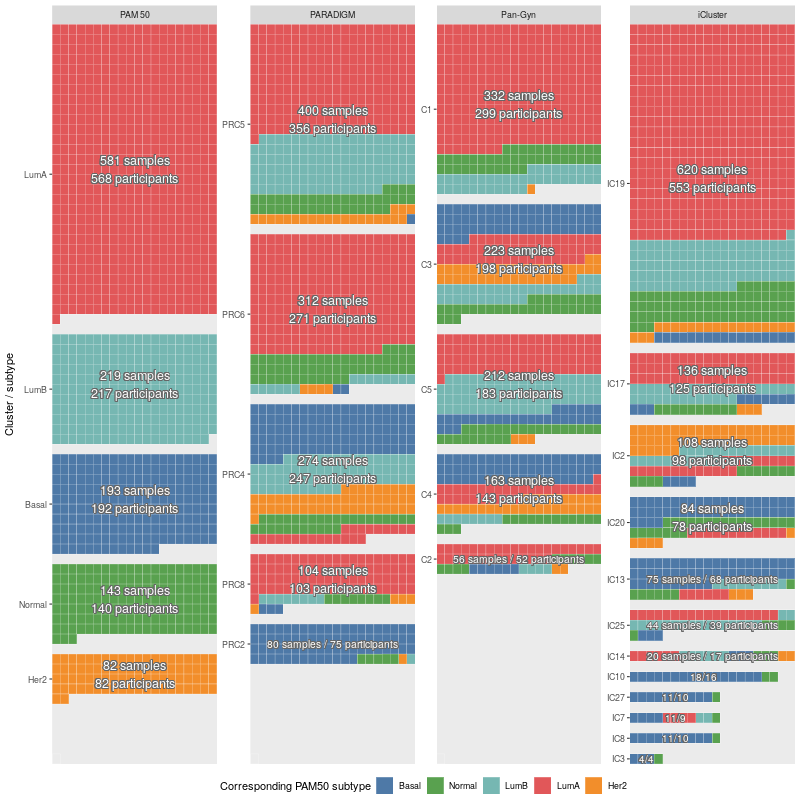

In [86]:
%%R -i heatmap -w 800 -h 800 -u px -i cluster_names -i annotations

pam50 = unique(heatmap$corresponding_pam50[heatmap$corresponding_pam50 != 'None'])
heatmap$corresponding_pam50[heatmap$corresponding_pam50 == 'None'] <- NA

g = (
    ggplot(heatmap, aes(x=x, y=y))
    + facet_wrap( ~ stratification, scales='free', ncol=4)
    + geom_tile(color='white', aes(fill=corresponding_pam50))
    + theme(
        legend.position='bottom',
        legend.margin=margin(t=-.5, unit='cm'),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )
    + shadowtext::geom_shadowtext(
        data=annotations, aes(label=label, size=4 * size),
        color='white',
        hjust=0.5,
        vjust=0.5,
        bg.color='#666666',
        bg.r=0.1
    )
    + scale_size_identity()
    + ggthemes::scale_fill_tableau(breaks=pam50, name='Corresponding PAM50 subtype')
    + scale_y_reverse(breaks=cluster_names$y, labels=cluster_names$name)
    + xlab('')
    + ylab('Cluster / subtype')
    + coord_cartesian(expand=F)
)
ggsave(file="stratifications_composition.png", plot=g, width=8*1.3, height=8*1.3, dpi=150)
g

### Participant-level comparison

In [87]:
from sklearn.metrics.cluster import v_measure_score, adjusted_rand_score

In [88]:
all_stratifications['stratification'] = all_stratifications.group.apply(names.get)

In [89]:
all_pairs = []
v_measure = []
tested_pairs = set()
for group, data in all_stratifications.groupby('stratification'):
    for group_2, data_2 in all_stratifications.groupby('stratification'):
        if group == group_2:
            continue
        pair = frozenset({group, group_2})
        if pair in tested_pairs:
            continue
        tested_pairs.add(pair)
        
        common_participants = list(set(data.participant) & set(data_2.participant))
        
        c1 = data.set_index('participant').loc[common_participants].cluster
        c2 = data_2.set_index('participant').loc[common_participants].cluster
        score = v_measure_score(c1, c2)
        rand = adjusted_rand_score(c1, c2)
        v_measure.append({
            'score': score,
            'comparison': f'{group} vs {group_2}',
            'y': max(map(len, [set(data.participant), set(data_2.participant)])),
            'label': f'V-measure score: {score * 100:.2f}%\nAdjusted Rand score: {rand * 100:.2f}%'
        })
        all_pairs.append(
            concat([data, data_2]).assign(
                comparison=f'{group} vs {group_2}',
                group_1=group,
                group_2=group_2
            )
        )

v_measure = DataFrame(v_measure)
all_pairs = concat(all_pairs)

In [90]:
len(all_pairs.participant.unique())

1099

In [91]:
%store all_pairs

Stored 'all_pairs' (AugmentedDataFrame)


In [92]:
counts['rank'] = counts.cluster.rank(ascending=False)

In [93]:
colors_order = counts.set_index('group').loc[all_pairs.cluster.cat.categories]['rank']

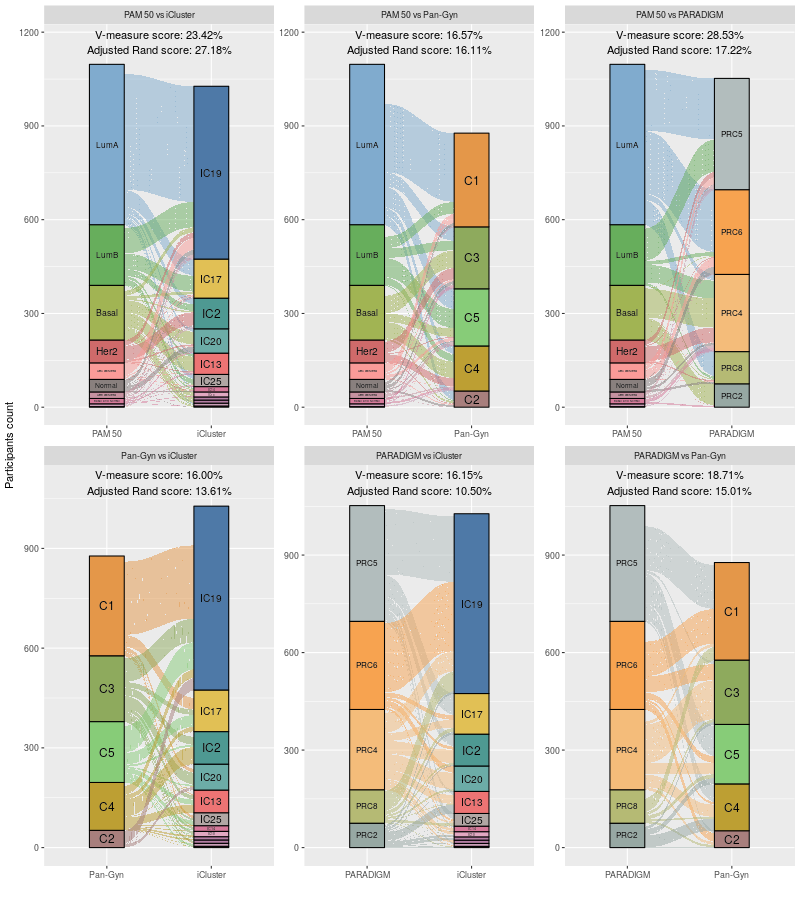

In [94]:
%%R -w 800 -h 900 -u px -i v_measure -i all_pairs -i colors_order
pal = ggthemes::tableau_color_pal("Tableau 20")
palette = colorRampPalette(pal(20))
g = (
    ggplot(all_pairs, aes(x=stratification, stratum=cluster, alluvium=participant, fill=cluster))
    + ggalluvial::geom_flow(stat="alluvium", lode.guidance="leftright")
    + ggalluvial::geom_stratum()
    + facet_wrap(~ comparison, scales='free', ncol=3)
    + theme()
    + ggfittext::geom_fit_text(stat='stratum', label.strata=T, min.size=2, width=1/4, color='white', alpha=.5)
    + ggfittext::geom_fit_text(stat='stratum', label.strata=T, min.size=2, width=1/4)
    + ylab('Participants count')
    + xlab('')
    + guides(fill=F)
    + geom_text(data=v_measure, aes(label=label, x=1.5, y=y+70), vjust=0.5, inherit.aes=F)
    + scale_fill_manual(values=palette(32)[colors_order])
)
ggsave(file="side_by_side_stratification_comparison.png", plot=g, width=8*1.3, height=9*1.3, dpi=150)
g

Stratifications were compared with adjusted Rand Index and V-measure (sklearn) using the common subset of participants. While high values were not expected given drastically different numbers of clusters, certain similarities are apparent.  
By all measures Pan-Gyn differs the most from PAM50 stratification, while PARADIGM and Pan-Gyn share the most similarities.